# Consensus scoring with feature (conformation) selection

In [31]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [32]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

In [33]:
# Read the MDS resutls
import pickle

# Pocket MDS
path_mds_obj_pk = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pocket_402_obj.pyobj')
with open(path_mds_obj_pk, 'rb') as f:
    mds_pocket_402 = pickle.load(f)
    
# Pisani MDS
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [34]:
# Helper function
%run ./helper_functions_S6.ipynb

### Loading the data:

In [35]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

### Selecting the best conformation docking scores per dataset

In [36]:
bc_csar, bc_csar_auc = get_best_conformation('CSAR', 'Dk_sc')

print(F'Best conf. in CSAR:', bc_csar, ', AUC:', bc_csar_auc)

Best conf. in CSAR: 2vv9 , AUC: 0.8486425339366516


In [37]:
bc_dud, bc_dud_auc = get_best_conformation('DUD', 'Dk_sc')

print(F'Best conf. in DUD:', bc_dud, ', AUC:', bc_dud_auc)

Best conf. in DUD: 3le6 , AUC: 0.6750040180006429


In [38]:
bc_dekois, bc_dekois_auc = get_best_conformation('DEKOIS', 'Dk_sc')

print(F'Best conf. in DEKOIS:', bc_dekois, ', AUC:', bc_dekois_auc)

Best conf. in DEKOIS: 2iw6 , AUC: 0.7904375


### Swarm plot con la media mediana de los tres

#### Get the AUC scores of each conformations in each database

In [39]:
score_type = 'Dk_sc'
df_swarm = pd.DataFrame()

for db_name in scores_dic:
    _X = scores_dic[db_name][score_type]['X']
    _y = scores_dic[db_name][score_type]['y']
    auc_scores = _X.apply(lambda x: roc_auc_score(y_true =_y, 
                                  y_score = -1 * x), axis = 0)
    df_swarm[db_name + '_vrd'] = auc_scores
    
_means = df_swarm.mean(axis = 0).values

data = df_swarm.melt()

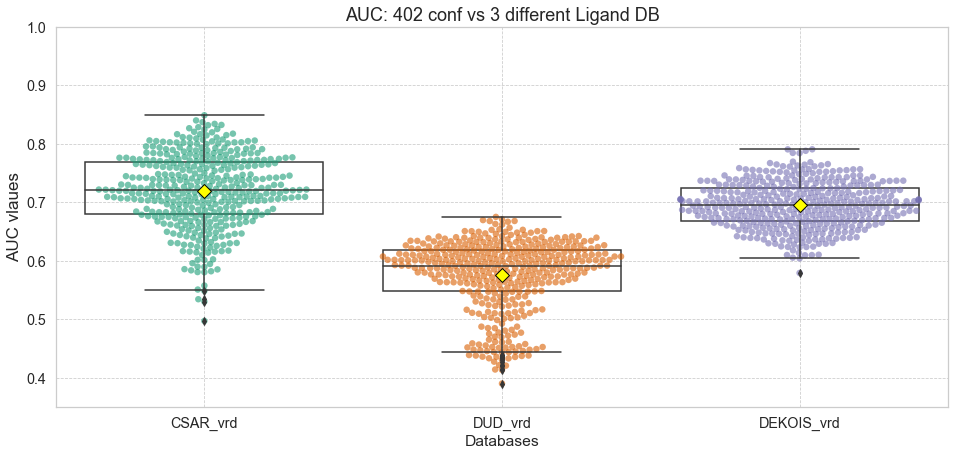

In [40]:
fig, axes = plt.subplots(figsize=(16, 7))
# plot the swarm and box plots
with sns.plotting_context("paper"):
    sns.set(style = 'whitegrid', palette = 'Dark2')
    sns.swarmplot(x = "variable", y = "value", data = data, ax = axes, alpha=0.6, s = 6.5)
    sns.boxplot(x = "variable", y = "value", data = data, ax = axes, zorder=100,
               showmeans=True, meanprops={"marker":"D","markerfacecolor":"yellow", 
                                          "markeredgecolor":"black", "markersize": 10})

    for i in range(3):
        axes.artists[i].set_facecolor('none')

    axes.set_title('AUC: 402 conf vs 3 different Ligand DB', fontsize=18)
    axes.grid(linestyle='--', linewidth='0.8')
    plt.xlabel("Databases")
    plt.ylabel("AUC vlaues", fontsize=17)
    plt.ylim(0.35, 1)
    plt.show()

#### Some useful variables

In [41]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/consensus_scoring'

# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_sc', 'Dk_lef']
# List of datasets to be used as test
test_keys = ['CSAR', 'DUD', 'DEKOIS']

# K-means Conformation Selection

#### Get the protein conformations using k-means for k in range 1 to 402
We start computing the list of conformations for each $k$ value in k-means, this is because in all function calls we are using a `random_state` parameter which means the conformations considered as medoids would be the same each time. Therefore we compute them once to avoid recompute *k-means clustering* each time.

- `random_state = 0` is used in order to get the same k conformations to evaluate all the machine learning models.

#### Using Pisani Subspace

In [42]:
output_dir = '../data/ml_evaluations'
file_list_of_confs_per_k =  F'{output_dir}/list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
    df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
    df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

In [43]:
df_confs_per_k

,list_of_confs_pisani
0,[18]
1,"[95, 300]"
2,"[77, 300, 277]"
3,"[77, 300, 91, 203]"
4,"[300, 295, 203, 273, 137]"
...,...
397,"[236, 171, 219, 284, 341, 203, 351, 314, 91, 9..."
398,"[236, 171, 219, 284, 341, 203, 351, 314, 91, 9..."
399,"[236, 171, 219, 284, 341, 203, 351, 314, 91, 9..."
400,"[236, 171, 219, 284, 341, 203, 351, 314, 91, 9..."


#### Using Pocket subspace

In [44]:
output_dir = '../data/ml_evaluations'
file_list_of_confs_per_k =  F'{output_dir}/list_of_confs_per_k_pocket_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k_POCKET = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pocket_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
    df_confs_per_k_POCKET = pd.DataFrame({'list_of_confs_pocket': list_of_confs_per_k})
    df_confs_per_k_POCKET.to_json(file_list_of_confs_per_k)

df_confs_per_k_POCKET.sort_index(inplace=True)

In [68]:
df_confs_per_k_POCKET

,list_of_confs_pocket
0,[149]
1,"[219, 297]"
2,"[267, 313, 297]"
3,"[301, 267, 297, 137]"
4,"[137, 101, 76, 224, 311]"
...,...
397,"[236, 121, 324, 311, 331, 321, 209, 69, 301, 1..."
398,"[236, 121, 324, 311, 331, 321, 209, 69, 301, 1..."
399,"[236, 121, 324, 311, 331, 321, 209, 69, 301, 1..."
400,"[236, 121, 324, 311, 331, 321, 209, 69, 301, 1..."


### Recursive Feature Selection

The set of protein conformations were selected using Recursive Feature Selection. Take into account that this procedure was use to evaluate the performance of a given ML model and that the chosen conformations are going to be tested here by performing Consensus Scorings.

#### Load of the conformations selected by using RFE with Logistic Regression and Ridge Regularization.

In [45]:
fet_mtx_LogReg = np.load('../data/ml_evaluations/ml_models/' + \
                         'DUD_DEKOIS_LogRg_RFE_Dksc_range_1_402.obj_RFE-Features_.npy')

In [46]:
# Get the number of features
list_of_confs_per_k_RFE = []
for i in range(0, 402):
    positions = np.where(fet_mtx_LogReg[i,:])
    list_of_confs_per_k_RFE.append(positions)
df_confs_per_k_RFE = pd.DataFrame({'list_of_confs_RFE': list_of_confs_per_k_RFE})

df_confs_per_k_RFE.sort_index(inplace=True)

### Correalted Features
Set of proteins remained after dropping of highly correlated features.

In [73]:
# Get the number of features
file_list_of_confs_per_k_correlated =  F'../data/ml_evaluations/list_of_confs_per_k_drop_correlated_features.json'
df_confs_per_k_CORRELATED = pd.read_json(file_list_of_confs_per_k_correlated)
df_confs_per_k_CORRELATED.sort_index(inplace=True)

In [74]:
df_confs_per_k_CORRELATED

,list_of_confs_pisani
0,[34]
1,"[34, 161]"
2,"[34, 56, 161]"
3,"[34, 56, 161, 240]"
4,"[34, 56, 161, 240, 349]"
...,...
397,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
398,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
399,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
400,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


### Visualization Example (k-means in MDS Pisani space)

In [48]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
output_notebook()

Loading BokehJS ...

In [49]:
# Kmeans over the first two dimensions
fd = 2
_X = mds_pisani_402[0][:fd].T

n_clusters = 5
kmc = KMeans(n_clusters = n_clusters, random_state = 0)
kmc.fit( _X )

# Create the datasource
data_mds = ColumnDataSource({
    'x': _X.T[0],
    'y': _X.T[1],
    'cluster': kmc.labels_.astype('str')
})

# Create the color palette
CLUSTERS = np.unique(kmc.labels_.astype('str'))
color_map = factor_cmap('cluster', 
                        palette= viridis(len(CLUSTERS)), factors = CLUSTERS)
# Create the initial figure
f = figure(title = F'K-Means Clustering Example (k = {n_clusters})', 
           active_scroll='wheel_zoom')
# Plot the reference space
f.circle('x', 'y', color = color_map, source = data_mds, size = 6)
# Plot the centroids
f.triangle(x = kmc.cluster_centers_[:,0], 
           y = kmc.cluster_centers_[:,1], color = (220,20,60, 0.5), size = 10,
          line_color = 'black', legend_label = 'Centroids')
# Plot the medoids
medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, 
                              n_clusters = n_clusters, random_state = 0)
_X_medoids = _X[ medoids_idx, :]
# Plot medoids
f.circle(x = _X_medoids.T[0], 
           y = _X_medoids.T[1], color = (255, 241, 116, 0), size = 10,
          line_color = 'black',  legend_label = 'Medoids')
f.xaxis.axis_label = 'First Dimension'
f.yaxis.axis_label = 'Second Dimension'
show(f)

In [50]:
# K = 50
# distortions = np.zeros(K)

# for k in range(K):
#     kmc = KMeans(n_clusters = k + 1, random_state = 0)
#     kmc.fit(_X)
#     distortions[k] = kmc.inertia_
    
# f_2 = figure(title='Elbow method for kmeans clustering', plot_width = 900, plot_height = 300)
# f_2.line(x = range(1, K+1), y = distortions)
# f_2.circle(x = range(1, K+1), y = distortions)
# f_2.xaxis.axis_label = 'k clusters'
# f_2.yaxis.axis_label = 'Distortion'
# show(f_2)

## Consensus Scoring

Sources: 
> 1. _[Exponential consensus ranking improves the outcome in docking and receptor ensemble docking](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6435795/)_ 
- _[How Does Consensus Scoring Work for Virtual Library Screening? An Idealized Computer Experiment](https://pubs.acs.org/doi/10.1021/ci010025x)_


## *Rank by number*
<div style='background-color: #F9E5AB; min-height: 10px'></div>

> The final score of each ligand $i$ ($R_bN_i$) corresponds to the *mean score* of ligand $i$ from a set of $n$ conformations.

> $R_bN_i = \frac{1}{n}\sum_js_i^j,$

where $n$ is the number of conformations, and $s_i^j$ is the docking score of the molecule $i$ with the $j$ conformation.

In [51]:
def get_rank_by_number(df):
    '''Get a dataframe of m*n values and returns a numpy array of means per row'''
    # times -1 because roc_auc_score assumes higher is better
    df_means = df.mean(axis = 1).to_numpy() * -1
    return df_means

#### Random Selection

In [52]:
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'random'

Rbn_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                test_keys, consensus_name, method = method, overwrite = True)
# Rename keys to simplify plotting
Rbn_rd_dict = { k.split('_')[0]: v for k, v in Rbn_rd_dict.items()
                   if k.split('_')[1] == 'Dksc'}

#### k-means Selection

In [53]:
%%time
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'kmeans'
df_precomputed_medoids = {'pisani': df_confs_per_k, 'pocket': df_confs_per_k_POCKET}

Rbn_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
# Rename keys to simplify plotting
Rbn_km_dict = { k.split('_')[0]: pd.DataFrame({k: v['pisani']}).T for k, v in Rbn_km_dict.items()
                   if k.split('_')[1] == 'Dksc'}

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 81.1 ms


#### RFE Selection

In [54]:
%%time
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'rfe'
df_precomputed_medoids = {'rfe': df_confs_per_k_RFE}
file_sufix = '_RegLog'

Rbn_rfe_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbn_rfe_dict = { k.split('_')[0]: pd.DataFrame({k: v['rfe']}).T for k, v in Rbn_rfe_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 7.63 ms, sys: 0 ns, total: 7.63 ms
Wall time: 100 ms


#### Correlated Features

In [75]:
%%time
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'correlated'
df_precomputed_medoids = {method: df_confs_per_k_CORRELATED}
file_sufix = ''

Rbn_corr_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbn_corr_dict = { k.split('_')[0]: pd.DataFrame({k: v[method]}).T for k, v in Rbn_corr_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 7.57 s, sys: 0 ns, total: 7.57 s
Wall time: 7.6 s


<h4>Visualization: <span class="text-muted">Rank-by-number</span></h4>

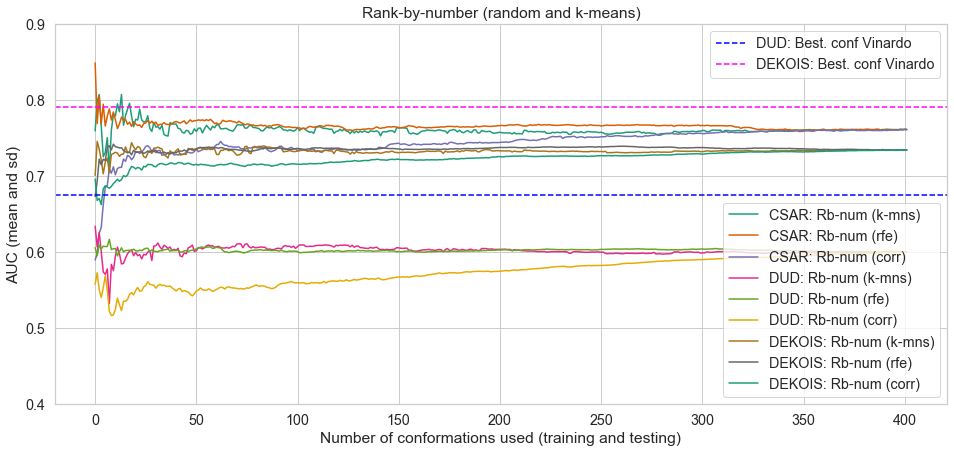

In [77]:
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {#'Rb-num (rand)': Rbn_rd_dict, 
                'Rb-num (k-mns)': Rbn_km_dict,
                'Rb-num (rfe)': Rbn_rfe_dict,
                'Rb-num (corr)': Rbn_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Rank-by-number (random and k-means)')
plt.show()

### Best score (Merging and shrinking strategy)

Also mentioned as *Merging and shrinking strategy* by Palacio-Rodríguez, et al. (2019).

For each molecule $i$, get the lowest score of the $n$ scores calculated.
> $
\begin{aligned}
best\ score_i = min(s_i),
\end{aligned}
$

where $s_i$ is a vector of $n$ scores, belonging to the molecule $i$, in which each position $j$ corresponds to the docking score between the molecule $i$ and each of the $n$ protein conformations.

In [79]:
def get_best_score(df):
    '''Get a dataframe of m*n values and returns a numpy array of best scores per row'''
    df_best = df.min(axis = 1)
    # (times -1 because roc_auc_score in the following line assumes higher is better)
    return df_best.to_numpy() * -1

#### Random Selection

In [82]:
func = get_best_score
consensus_name = 'Rbs'
method = 'random'

Rbs_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                test_keys, consensus_name, method = method, overwrite = True)
# Rename keys to simplify plotting
Rbs_rd_dict = { k.split('_')[0]: v for k, v in Rbs_rd_dict.items()
               if k.split('_')[1] == 'Dksc'}

#### k-means Selection

In [83]:
func = get_best_score
consensus_name = 'Rbs'
method = 'kmeans'
df_precomputed_medoids = {'pisani': df_confs_per_k, 'pocket': df_confs_per_k_POCKET}

Rbs_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
# Rename keys to simplify plotting
Rbs_km_dict = { k.split('_')[0]: pd.DataFrame({k: v['pisani']}).T for k, v in Rbs_km_dict.items()
                   if k.split('_')[1] == 'Dksc'}

#### RFE Selection (from ML models; only for comparing results)

In [84]:
%%time
func = get_best_score
consensus_name = 'Rbs'
method = 'rfe'
df_precomputed_medoids = {'rfe': df_confs_per_k_RFE}
file_sufix = '_RegLog'

Rbs_rfe_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbs_rfe_dict = { k.split('_')[0]: pd.DataFrame({k: v['rfe']}).T for k, v in Rbs_rfe_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 4.46 ms, sys: 0 ns, total: 4.46 ms
Wall time: 81.1 ms


#### Dropping Correalted Features

In [80]:
%%time
func = get_best_score
consensus_name = 'Rbs'
method = 'correlated'
df_precomputed_medoids = {method: df_confs_per_k_CORRELATED}
file_sufix = ''

Rbs_corr_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbs_corr_dict = { k.split('_')[0]: pd.DataFrame({k: v[method]}).T for k, v in Rbs_corr_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 7.73 s, sys: 0 ns, total: 7.73 s
Wall time: 7.75 s


<h4>Visualization: <span class="text-muted">Best score</span></h4>

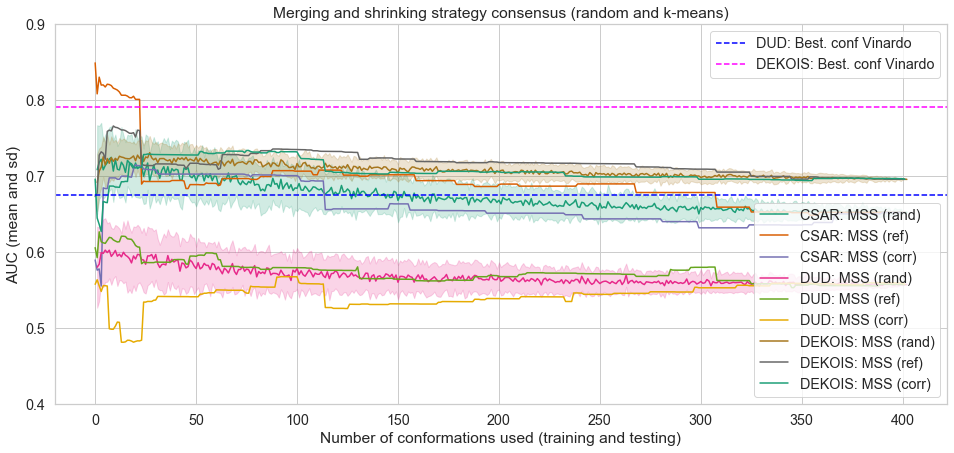

In [87]:
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'MSS (rand)': Rbs_rd_dict, 
                #'MSS (k-mns)': Rbs_km_dict,
                'MSS (ref)': Rbs_rfe_dict,
                'MSS (corr)': Rbs_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.title('Merging and shrinking strategy consensus (random and k-means)')
plt.show()

## *Rank-by-rank*
<div style='background-color: #F9E5AB; min-height: 10px'></div>

For each conformation $j$ the $m$ molecules are ranked according to their docking score with that conformation. Therefore, the molecule with the best score is assigned with the value 1, the second one with the best score is assigned with the value 2, and so on, until the molecule with the worst value is assigned with the value $m$. Finally, the average rank of each molecule is compute taking into account its rank in all the $n$ conformations.

> $
\begin{aligned}
R_bR_i = \frac{1}{n}\sum_jr^i_j,
\end{aligned}
$

where $n$ is the number of protein conformations, and $r^i_j$ is the rank position of the molecule $i$ in the ranked score obtained in the protein conformation $j$.

In [89]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # First, we get the ranking positions
    # For each ligand i we get the average score among the n conformations
    df_rank_by_rank = df_ranks.mean(axis = 1)
    return df_rank_by_rank.to_numpy() * -1

#### Random Selection

In [90]:
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'random'

Rbr_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                       test_keys, consensus_name, method = method, overwrite = True)
# Rename keys to simplify plotting
Rbr_rd_dict = { k.split('_')[0]: v for k, v in Rbr_rd_dict.items()
               if k.split('_')[1] == 'Dksc'}

#### K-means Selection

In [91]:
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'kmeans'
df_precomputed_medoids = {'pisani': df_confs_per_k, 'pocket': df_confs_per_k_POCKET}

Rbr_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
# Rename keys to simplify plotting
Rbr_km_dict = { k.split('_')[0]: pd.DataFrame({k: v['pisani']}).T for k, v in Rbr_km_dict.items()
                   if k.split('_')[1] == 'Dksc'}

#### RFE Selection (from ML models; only for comparing results)

In [92]:
%%time
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'rfe'
df_precomputed_medoids = {'rfe': df_confs_per_k_RFE}
file_sufix = '_RegLog'

Rbr_rfe_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbr_rfe_dict = { k.split('_')[0]: pd.DataFrame({k: v['rfe']}).T for k, v in Rbr_rfe_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 105 ms


#### Dropping Correlated Features

In [93]:
%%time
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'correlated'
df_precomputed_medoids = {method: df_confs_per_k_CORRELATED}
file_sufix = ''

Rbr_corr_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, file_sufix = file_sufix,
                  df_precomputed_medoids = df_precomputed_medoids, 
                  overwrite = True)
# Rename keys to simplify plotting
Rbr_corr_dict = { k.split('_')[0]: pd.DataFrame({k: v[method]}).T for k, v in Rbr_corr_dict.items()
                   if k.split('_')[1] == 'Dksc'}


CPU times: user 35.8 s, sys: 844 ms, total: 36.6 s
Wall time: 36.6 s


#### Visualization

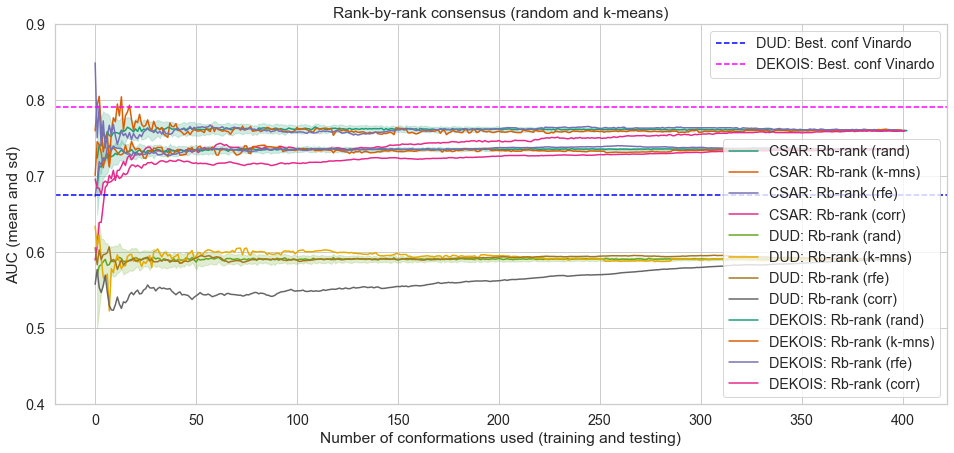

In [94]:
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Rb-rank (rand)': Rbr_rd_dict, 
                'Rb-rank (k-mns)': Rbr_km_dict,
                'Rb-rank (rfe)': Rbr_rfe_dict,
                'Rb-rank (corr)': Rbr_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.title('Rank-by-rank consensus (random and k-means)')
plt.show()

## *Rank-by-vote*
<div style='background-color: #F9E5AB; min-height: 10px'></div>
Each molecule $i$ receives a vote if it is ranked on top $x\%$ of the ranking list of each conformation. The final score of the molecule is given by  the sum of votes obtained in all the protein conformations.

> $R_bV_i(\chi) = \sum_j\delta^i_j,$

having:
> - $\delta _i = 1$ if $r^i_j \leq \chi m$
- $\delta _i = 0$ if $r^i_j > \chi m$  

where $\chi$ is the top fraction of the docking scores ranking of $m$ molecules, $r^i$ is the rank of molecule $i$ in the ranking of the conformation $j$, and $n$ is the number of conformations.

In [94]:
def get_rank_by_vote(df, chi = 10):
    df_ranks = df.rank(ascending=True) # Get ranks, ascending=True; lower values get lower positions
    x = np.floor(df.shape[0]/100 * chi) # Get the number of molecules inside chi
    rbv_array = df_ranks.to_numpy() # Convert to a numpy array
    # So, find values above chi (x) and assign the 0 or 1
    rbv_array = np.where(rbv_array > x, 0, 1)
    # Get the sum of votes
    rb_votes = rbv_array.sum(axis = 1)
    return rb_votes

#### Random Selection (unweighted)

In [95]:
%%time
func = get_rank_by_vote
consensus_name = 'Rbv'
method = 'random'

Rbv_random_chis = {}
chi_values = (1, 2, 5)
for chi in chi_values:
    file_sufix = F'_uw_c{chi}'

    Rbv_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method, n_reps = 30,
                  file_sufix = file_sufix, chi = chi, overwrite = True)
    # Rename keys to simplify plotting
    Rbv_random_chis[F'chi_{chi}'] =  { k.split('_')[0]: v for k, v in Rbv_rd_dict.items()
                                      if k.split('_')[1] == 'Dksc'}
    print(F'Finished with chi = {chi}')

Finished with chi = 1
Finished with chi = 2
Finished with chi = 5
CPU times: user 15.7 ms, sys: 20.1 ms, total: 35.7 ms
Wall time: 270 ms


####  K-means selection

In [96]:
%%time
func = get_rank_by_vote
consensus_name = 'Rbv'
method = 'kmeans'
df_precomputed_medoids = {'pisani': df_confs_per_k, 'pocket': df_confs_per_k_POCKET}

Rbv_kmeans_chis = {}
chi_values = (1, 2, 5)
for chi in chi_values:
    file_sufix = F'_uw_c{chi}'

    Rbv_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, 
                  file_sufix = file_sufix, chi = chi, 
                  df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
    # Rename keys to simplify plotting
    Rbv_kmeans_chis[F'chi_{chi}'] = \
    { k.split('_')[0]: pd.DataFrame({k: v['pisani']}).T for k, v in Rbv_km_dict.items()
                   if k.split('_')[1] == 'Dksc'}

CPU times: user 14.8 ms, sys: 160 µs, total: 15 ms
Wall time: 72.7 ms


In [98]:
%%time
func = get_rank_by_vote
consensus_name = 'Rbv'
method = 'rfe'
df_precomputed_medoids = {'rfe': df_confs_per_k_RFE}
file_sufix_ = '_RegLog'

# Only for chi = 2
Rbv_rfe_chis = {}
chi_values = [2]
for chi in chi_values:
    file_sufix = F'_c{chi}' + file_sufix_

    Rbv_rfe_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, 
                  file_sufix = file_sufix, chi = chi, 
                  df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
    # Rename keys to simplify plotting
    Rbv_rfe_chis[F'chi_{chi}'] = \
    { k.split('_')[0]: pd.DataFrame({k: v['rfe']}).T for k, v in Rbv_rfe_dict.items()
                   if k.split('_')[1] == 'Dksc'}

CPU times: user 37.2 s, sys: 9.25 ms, total: 37.3 s
Wall time: 37.2 s


### Visualization

#### Random selection

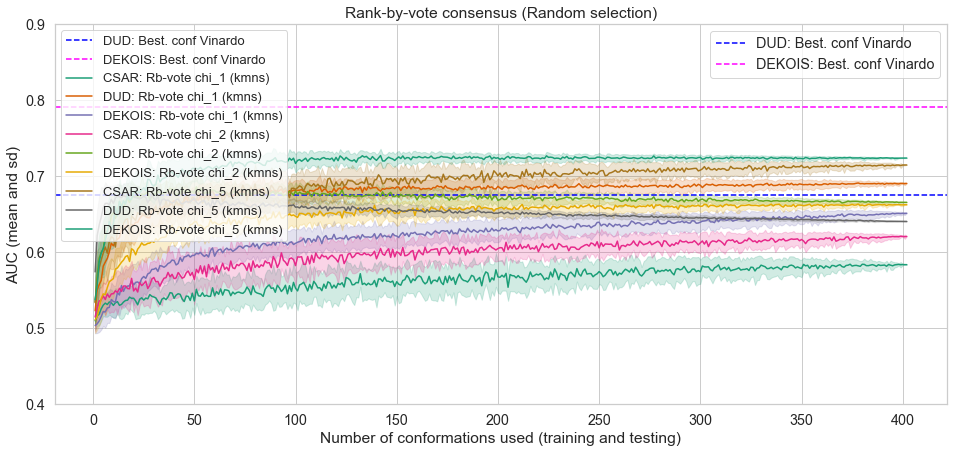

In [39]:
fig, ax = plt.subplots(figsize=(16, 7))

_plot_refs(ax) 
for key, value in Rbv_random_chis.items():
    _results_dic = {F'Rb-vote {key} (kmns)': value}
    _plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, plot_refs = False)
 
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.legend(fontsize='small')
plt.title('Rank-by-vote consensus (Random selection)')
plt.show()

#### k-means

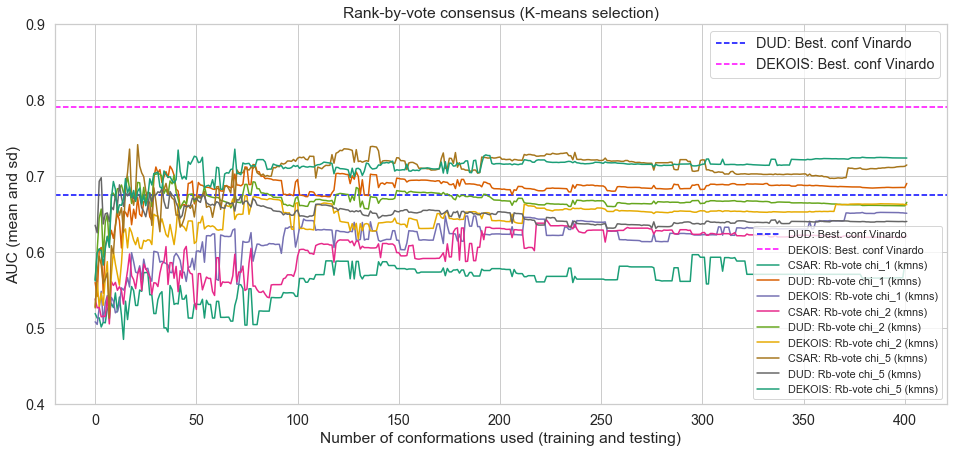

In [33]:
fig, ax = plt.subplots(figsize=(16, 7))

_plot_refs(ax) 
for key, value in Rbv_kmeans_chis.items():
    _results_dic = {F'Rb-vote {key} (kmns)': value}
    _plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, plot_refs = False)
 
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.legend(fontsize='x-small')
plt.title('Rank-by-vote consensus (K-means selection)')
plt.show()

## *Exponential Consensus Ranking*
<div style='background-color: #F9E5AB; min-height: 10px'></div>

It follows the same idea than the RIE and BEDROC metrics, taking into account the position of each molecule inside the ranked results following a exponential distribution. It is proposed by Palacio-Rodríguez, et al. (2019) as a scoring consensus using different docking programs:

> "*Exponential Consensus Ranking (ECR), a strategy to combine the results from
several scoring functions/docking programs using an exponential distribution for each individual rank.*"

For each molecule $i$ at the protein conformation $j$ the *exponential score* $p(r^j_i)$ is calculated as follows:

> $$p(r^j_i) = \frac{1}{\sigma}exp\left( - \frac{r_i^j}{\sigma} \right),$$

where $p(r^j_i)$ is the rank of the molecule $i$ in the docking scoring results of the protein conformation $j$, and $\sigma$ is the expected value of the exponential distribution. Just to remember, the exponential distribution (in the form $f(x) = \lambda e^{(- \lambda x)}$) has a mean and an standard deviation of $1/\lambda$ which here in $ECR$ is referred as $\sigma$: ($\sigma = 1 / \lambda$). As was said in a previous notebook for RIE and BEDROC metrics, the parameter $\sigma$ can be understood as a fraction of the ranked list where the weight is important.
As said by Palacio-Rodríguez, et al.:
> "*This parameter $(\sigma)$ establishes the number of molecules for each scoring function that will be considered, i.e., the threshold of the dataset to be taken into account for the consensus. *"

Finally, the final $ECR$ score $P(i)$ of each molecule $i$ is computed as follows:

> $$P(i) = \sum_{j=1}^n p(r^j_i) = \frac{1}{\sigma} \sum_{j=1}^n exp\left( - \frac{r_i^j}{\sigma} \right)$$

In [99]:
def get_exp_consensus_ranking(df, sigma = 2):
    # ascending=True; lower values get lower positions
    ranks_array = df.rank(ascending=True).to_numpy()
    # Apply the exponential function
    exp_ranks = (1/ sigma)*(np.exp( - ranks_array/sigma))
    
    # For each ligand i we get the average score among the n conformations
    ecs = exp_ranks.sum(axis = 1)
    return ecs

In [100]:
%%time
func = get_exp_consensus_ranking
consensus_name = 'Rexp'
method = 'random'

Rexp_random_sigs = {}
sigma_values = (1, 2, 5)
for sigma in sigma_values:
    file_sufix = F'_sig{sigma}'

    Rexp_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method, n_reps = 30,
                  file_sufix = file_sufix, sigma = sigma, 
                  df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
    # Rename keys to simplify plotting
    Rexp_random_sigs[F'sigma_{sigma}'] =  { k.split('_')[0]: v for k, v in Rexp_rd_dict.items()
                                           if k.split('_')[1] == 'Dksc'}
    print(F'Finished with  sigma = {sigma}')

Finished with  sigma = 1
Finished with  sigma = 2
Finished with  sigma = 5
CPU times: user 14.1 ms, sys: 24.2 ms, total: 38.3 ms
Wall time: 276 ms


In [101]:
%%time
func = get_exp_consensus_ranking
consensus_name = 'Rexp'
method = 'kmeans'
df_precomputed_medoids = {'pisani': df_confs_per_k, 'pocket': df_confs_per_k_POCKET}

Rexp_kmeans_sigs = {}
sigma_values = (1, 2, 5)
for sigma in sigma_values:
    file_sufix = F'_sig{sigma}'

    Rexp_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_precomputed_medoids,
                  file_sufix = file_sufix, sigma = sigma, overwrite = True)
    # Rename keys to simplify plotting
    Rexp_kmeans_sigs[F'chi_{sigma}'] = \
    { k.split('_')[0]: pd.DataFrame({k: v['pisani']}).T for k, v in Rexp_km_dict.items()
                   if k.split('_')[1] == 'Dksc'}

CPU times: user 11.2 ms, sys: 4.15 ms, total: 15.3 ms
Wall time: 141 ms


In [103]:
%%time
func = get_exp_consensus_ranking
consensus_name = 'Rexp'
method = 'rfe'
df_precomputed_medoids = {'rfe': df_confs_per_k_RFE}
file_sufix_ = '_RegLog'

# Only for chi = 2
Rexp_kmeans_sigs = {}
sigma_values = [2]
for sigma in sigma_values:
    file_sufix = F'_sig{sigma}' + file_sufix_

    Rexp_rfe_dict = consensus_wrapper(func, scores_dic, score_types, 
                  test_keys, consensus_name, method = method,
                  random_state = 0, 
                  file_sufix = file_sufix, sigma = sigma,
                  df_precomputed_medoids = df_precomputed_medoids, 
                                overwrite = True)
    # Rename keys to simplify plotting
    Rexp_kmeans_sigs[F'chi_{chi}'] = \
    { k.split('_')[0]: pd.DataFrame({k: v['rfe']}).T for k, v in Rexp_rfe_dict.items()
                   if k.split('_')[1] == 'Dksc'}

CPU times: user 50.1 s, sys: 34.9 ms, total: 50.1 s
Wall time: 50.1 s


### Visualization

#### Random Selection

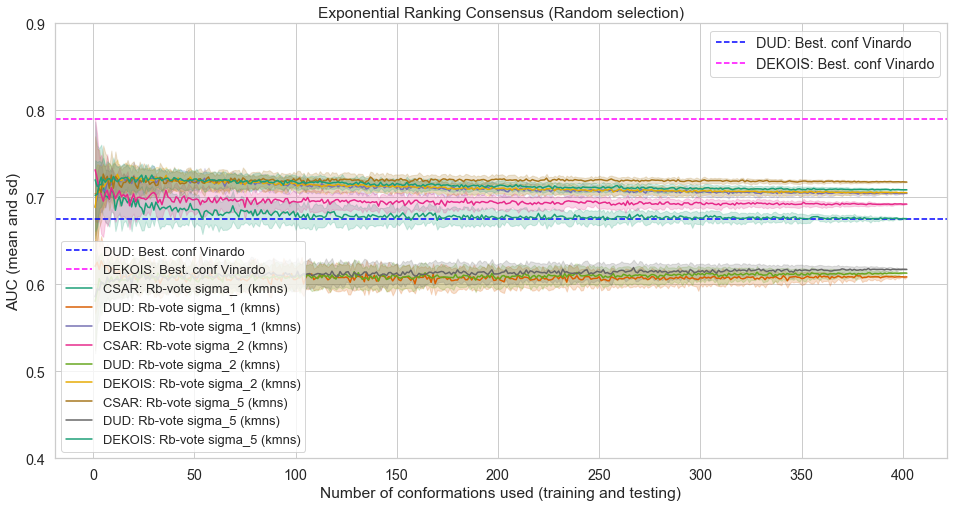

In [45]:
fig, ax = plt.subplots(figsize=(16, 8))

_plot_refs(ax) 
for key, value in Rexp_random_sigs.items():
    _results_dic = {F'Rb-vote {key} (kmns)': value}
    _plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, plot_refs = False)
 
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.legend(fontsize='small')
plt.title('Exponential Ranking Consensus (Random selection)')
plt.show()

#### K-means Selection

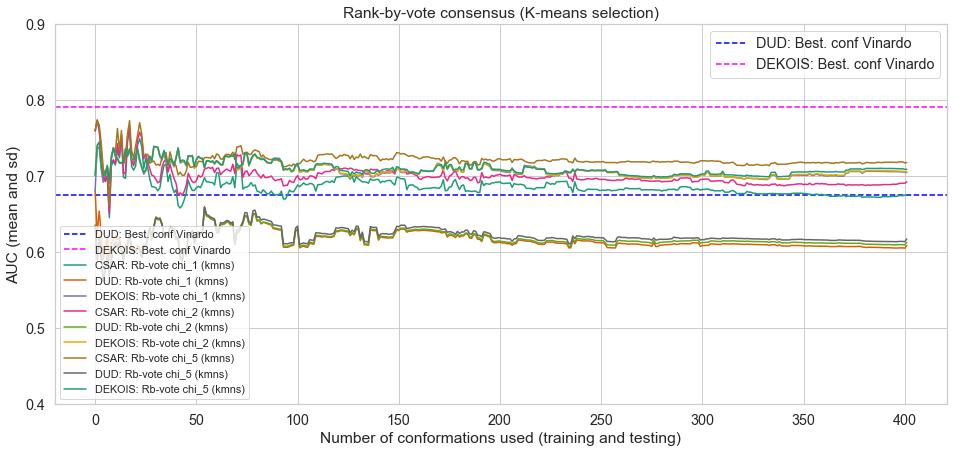

In [46]:
fig, ax = plt.subplots(figsize=(16, 7))

_plot_refs(ax) 
for key, value in Rexp_kmeans_sigs.items():
    _results_dic = {F'Rb-vote {key} (kmns)': value}
    _plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, plot_refs = False)
 
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
plt.legend(fontsize='x-small')
plt.title('Rank-by-vote consensus (K-means selection)')
plt.show()